## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt 

2026-02-01 12:24:33.620568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-01 12:24:33.634767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-01 12:24:33.639275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os, psutil
p = psutil.Process(os.getpid())
print("PID:", os.getpid())
print("RSS(MB):", p.memory_info().rss/1024/1024)

PID: 10253
RSS(MB): 818.48828125


In [3]:
import gc
gc.collect()

0

## 2. Loading Data

In [8]:
paths = []
ages = []

for i in os.listdir('../dataset/UTKFace/'): # select all image in dataset folder
    split = i.split('_')
    ages.append(int(split[0]))
    # images.append(Image.open('../dataset/UTKFace/' + i))
    paths.append(f'../dataset/UTKFace/{i}')

In [9]:
df = pd.DataFrame({'path': paths, 'age': ages})
df

,path,age
0,../dataset/UTKFace/100_0_0_20170112213500903.j...,100
1,../dataset/UTKFace/100_0_0_20170112215240346.j...,100
2,../dataset/UTKFace/100_1_0_20170110183726390.j...,100
3,../dataset/UTKFace/100_1_0_20170112213001988.j...,100
4,../dataset/UTKFace/100_1_0_20170112213303693.j...,100
...,...,...
23703,../dataset/UTKFace/9_1_3_20161220222856346.jpg...,9
23704,../dataset/UTKFace/9_1_3_20170104222949455.jpg...,9
23705,../dataset/UTKFace/9_1_4_20170103200637399.jpg...,9
23706,../dataset/UTKFace/9_1_4_20170103200814791.jpg...,9


'../dataset/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'

Age: 100


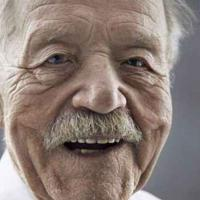

Age: 100


In [10]:
display(df['path'][0])
print("Age:",df['age'][0])

p = df.loc[0, 'path']
img = Image.open(p)

display(img)
print("Age:", df.loc[0, 'age'])

'../dataset/UTKFace/16_1_0_20170117133441179.jpg.chip.jpg'

Age: 16


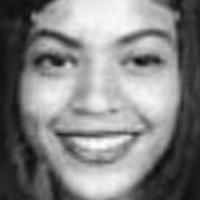

Age: 16


In [11]:
display(df['path'][1000])
print("Age:",df['age'][1000])

p = df.loc[1000, 'path']
img = Image.open(p)

display(img)
print("Age:", df.loc[1000, 'age'])

## 3. Visualising and Preparing Data

/tmp/ipykernel_10253/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<Axes: xlabel='age', ylabel='Density'>

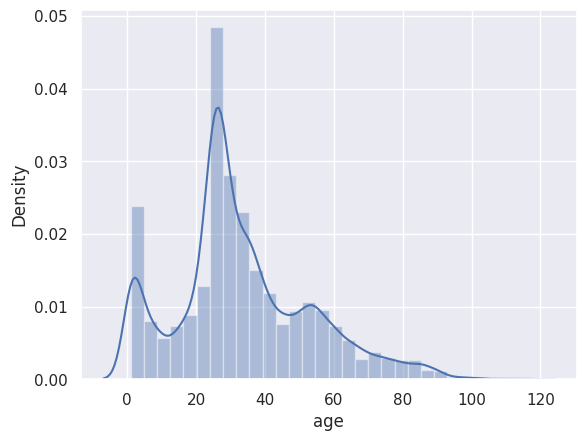

In [12]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

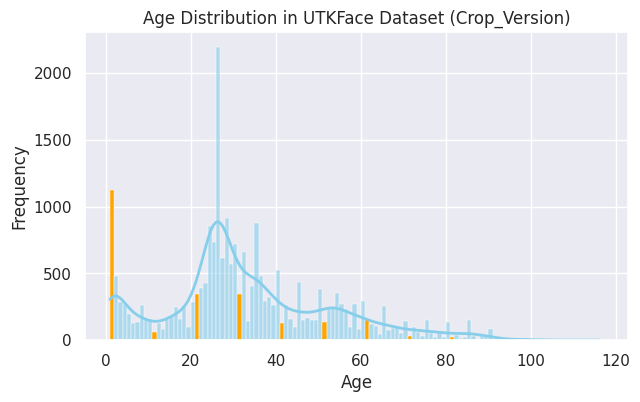

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already created and contains the 'Ages' column
plt.figure(figsize=(7, 4))

# Create a histogram with one bin per year
ax = sns.histplot(df['age'], bins=range(df['age'].min(), df['age'].max() + 2), kde=True, color="skyblue", line_kws={'linewidth': 2}, alpha=0.6)

# Get the patches used in the histogram
patches = ax.patches

# Color every 10th bin starting from 1 (1, 11, 21, ...) in orange
for patch in patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    if (int(bin_center) - 1) % 10 == 0:
        patch.set_facecolor('orange')

plt.title('Age Distribution in UTKFace Dataset (Crop_Version)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 3-1：找出極端數值，先裁切掉。 <br> 
3-1：Find the extreme values ​​and cut them out first.

In [14]:
import numpy as np

ages_np = np.array(ages, dtype=int)

unique, counts = np.unique(ages_np, return_counts=True)
top_idx = counts.argmax()

top_age = unique[top_idx]
top_count = counts[top_idx]
print("最多的年齡 =", top_age, "出現次數 =", top_count) #show the most frequent age and its count


最多的年齡 = 26 出現次數 = 2197


In [15]:
threshold = 500

mask = counts > threshold
result = list(zip(unique[mask], counts[mask]))

print(f"出現次數大於 {threshold} 的年齡：\n") #print ages with counts over than threshold
for age, count in result:
    print(f"{age} 歲出現 {count} 次")

出現次數大於 500 的年齡：

1 歲出現 1123 次
24 歲出現 859 次
25 歲出現 734 次
26 歲出現 2197 次
27 歲出現 615 次
28 歲出現 918 次
29 歲出現 570 次
30 歲出現 724 次
32 歲出現 664 次
35 歲出現 880 次
40 歲出現 526 次


把超過500筆資料的年齡，全部砍到剩下500張，以避免極端值影響模型泛化。 <br>
Reduced the age data from over 500 records to just 500 to avoid extreme values ​​affecting model generalization.

In [16]:
threshold = 500

df = (
    df.sample(frac=1, random_state=42)   # 先把整份資料打亂（等價於每組隨機） # shuffle the whole dataframe first (equivalent to random within each group)
      .groupby("age", group_keys=False)
      .head(threshold)                    # 每個年齡只保留前 500 筆 # keep only the first 500 samples for each age
      .reset_index(drop=True)
)

In [17]:
vc = df["age"].value_counts()

print("是否還存在 >500 的年齡？", (vc > 500).any())
print("最大值：", vc.max())
print("前 10 個最常見年齡：")
print(vc.head(10))


是否還存在 >500 的年齡？ False
最大值： 500
前 10 個最常見年齡：
age
32    500
25    500
35    500
28    500
27    500
40    500
24    500
26    500
1     500
29    500
Name: count, dtype: int64


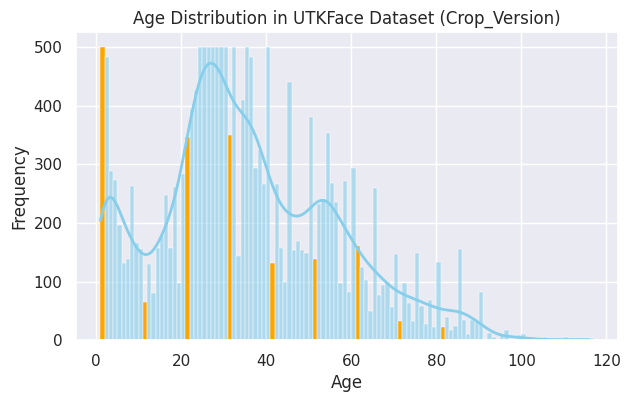

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already created and contains the 'Ages' column
plt.figure(figsize=(7, 4))

# Create a histogram with one bin per year
ax = sns.histplot(df['age'], bins=range(df['age'].min(), df['age'].max() + 2), kde=True, color="skyblue", line_kws={'linewidth': 2}, alpha=0.6)

# Get the patches used in the histogram
patches = ax.patches

# Color every 10th bin starting from 1 (1, 11, 21, ...) in orange
for patch in patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    if (int(bin_center) - 1) % 10 == 0:
        patch.set_facecolor('orange')

plt.title('Age Distribution in UTKFace Dataset (Crop_Version)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [19]:
under4s = []

for i in range(len(df)):
    if df['age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

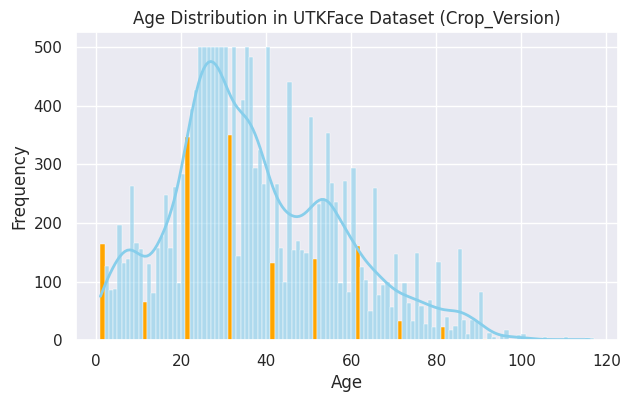

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already created and contains the 'Ages' column
plt.figure(figsize=(7, 4))

# Create a histogram with one bin per year
ax = sns.histplot(df['age'], bins=range(df['age'].min(), df['age'].max() + 2), kde=True, color="skyblue", line_kws={'linewidth': 2}, alpha=0.6)

# Get the patches used in the histogram
patches = ax.patches

# Color every 10th bin starting from 1 (1, 11, 21, ...) in orange
for patch in patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    if (int(bin_center) - 1) % 10 == 0:
        patch.set_facecolor('orange')

plt.title('Age Distribution in UTKFace Dataset (Crop_Version)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [21]:
# df = df[df['Ages'] < 80]
df = df[df['age'] < 80]

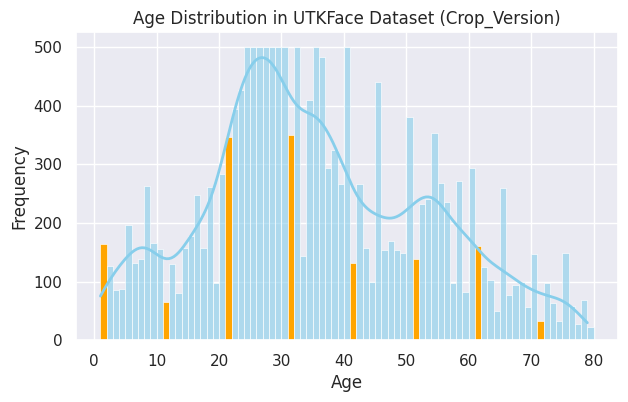

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already created and contains the 'Ages' column
plt.figure(figsize=(7, 4))

# Create a histogram with one bin per year
ax = sns.histplot(df['age'], bins=range(df['age'].min(), df['age'].max() + 2), kde=True, color="skyblue", line_kws={'linewidth': 2}, alpha=0.6)

# Get the patches used in the histogram
patches = ax.patches

# Color every 10th bin starting from 1 (1, 11, 21, ...) in orange
for patch in patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    if (int(bin_center) - 1) % 10 == 0:
        patch.set_facecolor('orange')

plt.title('Age Distribution in UTKFace Dataset (Crop_Version)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 4. Train Test Split

In [23]:
y_age = df["age"].astype(int).to_numpy()
X = df["path"].astype(str).to_numpy()

#這裡使用bins 將年齡分箱，是因為下面的train_test_split 使用了 stratify 參數。
#因為年齡是連續值，stratify 盡可能在切分訓練與測試集時，保留與原始資料相同的比例。
#並且，當bin <= 1 的情況出現，會出現分層上的錯誤。
bin_width = 5
bins = np.arange(y_age.min(), y_age.max() + bin_width + 1, bin_width)
y_bins = pd.cut(y_age, bins=bins, right=False, include_lowest=True)

In [24]:
# 3) 第一次切：先切出 train(80%)，剩下 20% 暫存起來（tmp）
X_train_age, X_tmp, y_train_age, y_tmp = train_test_split(
    X, y_age,
    test_size=0.2,
    random_state=42,
    stratify=y_bins
)

# 4) 第二次切：把 tmp(20%) 平分成 val(10%) 和 test(10%)
# y_tmp_bins = pd.cut(y_tmp, bins=bins, right=False, include_lowest=True)

X_val_age, X_test_age, y_val_age, y_test_age = train_test_split(
    X_tmp, y_tmp,
    test_size=0.5,       # tmp 的一半 -> 10% of total
    random_state=42
    # stratify=y_tmp_bins 
)

## 5. Creating the Model and Setting Pielines (And BatchSize)

In [26]:
# check if gpu is available
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
# Set the device
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
print(device)

/gpu:0


In [27]:
#build dataframe for train,val,test
df_train = pd.DataFrame({'path': X_train_age, 'age': y_train_age})
df_val   = pd.DataFrame({'path': X_val_age,   'age': y_val_age})
df_test  = pd.DataFrame({'path': X_test_age,  'age': y_test_age})

In [ ]:
#build data pipeline

import tensorflow as tf
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 64

IMG_SIZE = (200, 200)

def load_decode_resize(path, age):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)       # uint8
    img = tf.image.resize(img, IMG_SIZE)                    # float32
    return img, age

def make_ds(paths, ages, training):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages))
    if training:
        ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    ds = ds.map(load_decode_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_paths = df_train["path"].astype(str).to_numpy()
train_ages  = df_train["age"].astype(np.float32).to_numpy()

val_paths = df_val["path"].astype(str).to_numpy()
val_ages  = df_val["age"].astype(np.float32).to_numpy()

test_paths = df_test["path"].astype(str).to_numpy()
test_ages  = df_test["age"].astype(np.float32).to_numpy()


ds_train = make_ds(train_paths, train_ages, training=True)
ds_val   = make_ds(val_paths,   val_ages,   training=False)
ds_test  = make_ds(test_paths,  test_ages,  training=False)


I0000 00:00:1769948690.878493   10253 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769948690.878575   10253 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769948690.878592   10253 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769948691.759044   10253 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769948691.759109   10253 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [ ]:
#build model

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

with tf.device(device):
    agemodel = Sequential([
        Input(shape=(200, 200, 3)),

        # augmentation（只在 training=True 生效）
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

        # rescale（永遠生效）
        layers.Rescaling(1./255),

        # CNN backbone
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(1)
    ])

agemodel.compile(
    loss="mean_squared_error",
    optimizer=optimizers.Adam(learning_rate=0.0002),
    metrics=["mae"]
)


In [30]:
agemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_translation (Random  (None, 200, 200, 3)       0         
 Translation)                                                    
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        1

## 6. Start Training

In [ ]:
import datetime
from tensorflow.keras.callbacks import TensorBoard
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # to suppress some log messages

history1 = agemodel.fit(ds_train, epochs=50, shuffle=True, validation_data=ds_val)

## 7. Visualization Training Result

### 7-1 : Batch Size = 64 (done)

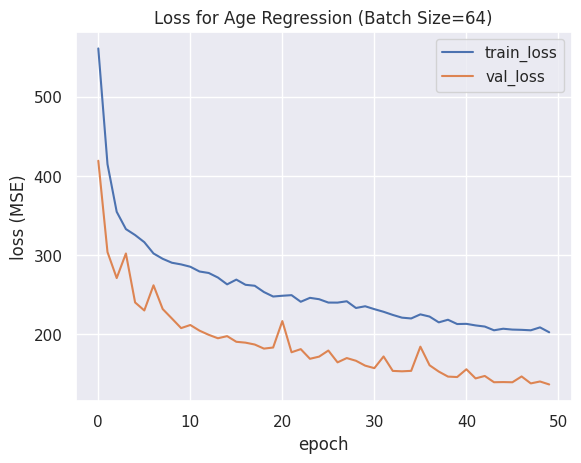

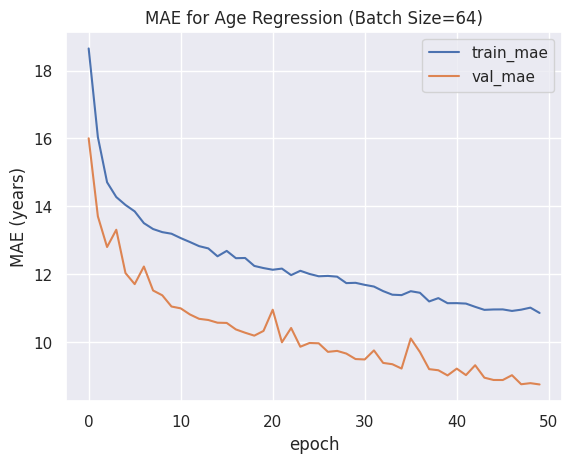

In [ ]:
import matplotlib.pyplot as plt
save_dir = "/workspace/output"
os.makedirs(save_dir, exist_ok=True)


plt.figure()
plt.title('Loss for Age Regression (Batch Size=64)')
plt.plot(history1.history["loss"], label="train_loss")
plt.plot(history1.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss (MSE)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_loss_batch64.png"))
plt.show()

plt.figure()
plt.title('MAE for Age Regression (Batch Size=64)')
plt.plot(history1.history["mae"], label="train_mae")
plt.plot(history1.history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("MAE (years)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_mae_batch64.png"))
plt.show()

In [ ]:
import numpy as np
import pandas as pd

h = history1.history  

df_hist = pd.DataFrame(h)
df_hist.index = df_hist.index + 1  # epoch從1開始比較直觀

# 找 val_loss 最低的 epoch（你也可以改成 val_mae 最低）
best_epoch = int(df_hist["val_loss"].idxmin())
best_row = df_hist.loc[best_epoch]

print("===== 最佳驗證表現（以 val_loss 最低） =====")
print(f"Best epoch: {best_epoch}")
print(best_row.to_string())

print("\n===== 最終 epoch 數值 =====")
print(df_hist.iloc[-1].to_string())


===== 最佳驗證表現（以 val_loss 最低） =====
Best epoch: 50
loss        202.549164
mae          10.855803
val_loss    136.678635
val_mae       8.747440

===== 最終 epoch 數值 =====
loss        202.549164
mae          10.855803
val_loss    136.678635
val_mae       8.747440


In [ ]:
test_loss, test_mae = agemodel.evaluate(ds_test, verbose=0)
print("===== Test set =====")
print("test_loss(MSE):", float(test_loss))
print("test_mae:", float(test_mae))

===== Test set =====
test_loss(MSE): 131.20811462402344
test_mae: 8.805939674377441


In [ ]:
save_dir = "/workspace/csv_result"
os.makedirs(save_dir, exist_ok=True)

out_csv = "training_history_V2_batchSize64_0126.csv"
df_hist.to_csv(os.path.join(save_dir, out_csv), index_label="epoch")
print("saved:", out_csv)

saved: training_history_V2_batchSize64_0126.csv


In [ ]:
save_dir = "/workspace/models"
os.makedirs(save_dir, exist_ok=True)

agemodel.save(os.path.join(save_dir, "Age_Model_V2_batchSize64_0126.keras"))  

### 7-2 batch Size = 96

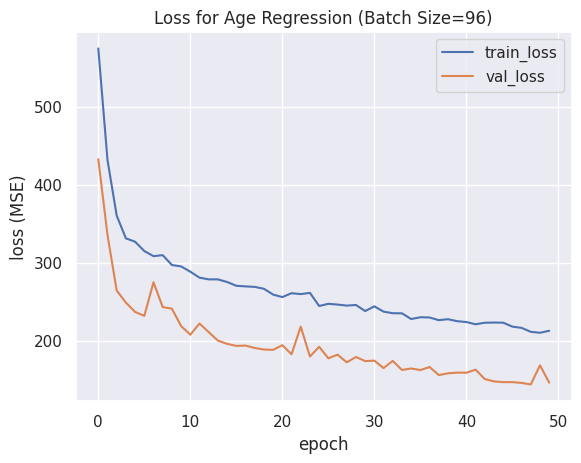

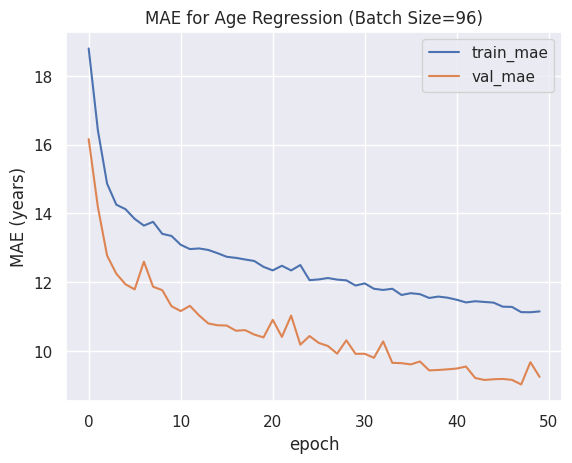

In [31]:
import matplotlib.pyplot as plt
save_dir = "/workspace/output"
os.makedirs(save_dir, exist_ok=True)


plt.figure()
plt.title('Loss for Age Regression (Batch Size=96)')
plt.plot(history1.history["loss"], label="train_loss")
plt.plot(history1.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss (MSE)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_loss_batch96.png"))
plt.show()

plt.figure()
plt.title('MAE for Age Regression (Batch Size=96)')
plt.plot(history1.history["mae"], label="train_mae")
plt.plot(history1.history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("MAE (years)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_mae_batch96.png"))
plt.show()

In [ ]:
import numpy as np
import pandas as pd

h = history1.history  
df_hist = pd.DataFrame(h)
df_hist.index = df_hist.index + 1  # epoch從1開始比較直觀

# 找 val_loss 最低的 epoch（你也可以改成 val_mae 最低）
best_epoch = int(df_hist["val_loss"].idxmin())
best_row = df_hist.loc[best_epoch]

print("===== 最佳驗證表現（以 val_loss 最低） =====")
print(f"Best epoch: {best_epoch}")
print(best_row.to_string())

print("\n===== 最終 epoch 數值 =====")
print(df_hist.iloc[-1].to_string())


===== 最佳驗證表現（以 val_loss 最低） =====
Best epoch: 48
loss        211.469223
mae          11.133988
val_loss    143.993607
val_mae       9.032703

===== 最終 epoch 數值 =====
loss        212.767639
mae          11.154892
val_loss    146.310806
val_mae       9.251659


In [28]:
test_loss, test_mae = agemodel.evaluate(ds_test, verbose=0)
print("===== Test set =====")
print("test_loss(MSE):", float(test_loss))
print("test_mae:", float(test_mae))

===== Test set =====
test_loss(MSE): 140.85452270507812
test_mae: 9.214574813842773


In [30]:
save_dir = "/workspace/csv_result"
os.makedirs(save_dir, exist_ok=True)

out_csv = "training_history_V2_batchSize96_0126.csv"
df_hist.to_csv(os.path.join(save_dir, out_csv), index_label="epoch")
print("saved:", out_csv)

saved: training_history_V2_batchSize96_0126.csv


In [ ]:
save_dir = "/workspace/models/Predict_Age_Model"
os.makedirs(save_dir, exist_ok=True)

agemodel.save(os.path.join(save_dir, "Age_Model_V2_batchSize96_0126.keras"))  

### 7-3 batch Size = 128

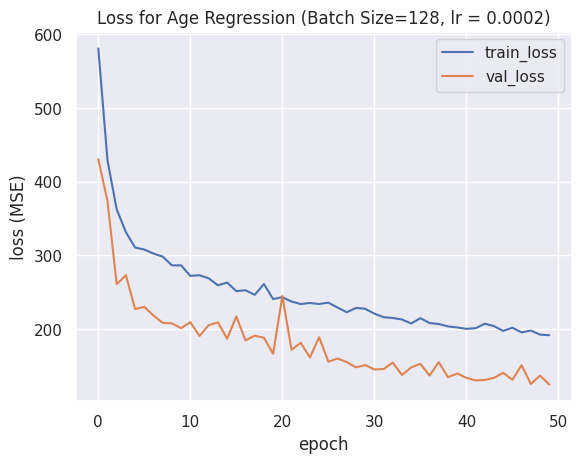

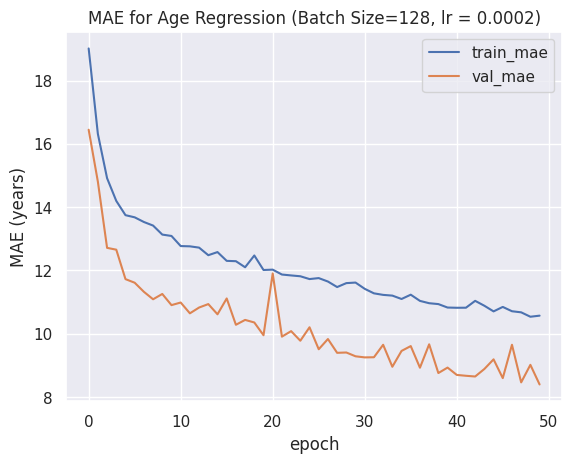

In [27]:
import matplotlib.pyplot as plt
save_dir = "/workspace/output"
os.makedirs(save_dir, exist_ok=True)


plt.figure()
plt.title('Loss for Age Regression (Batch Size=128, lr = 0.0002)')
plt.plot(history1.history["loss"], label="train_loss")
plt.plot(history1.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss (MSE)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_loss_batch128.png"))
plt.show()

plt.figure()
plt.title('MAE for Age Regression (Batch Size=128, lr = 0.0002)')
plt.plot(history1.history["mae"], label="train_mae")
plt.plot(history1.history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("MAE (years)")
plt.legend()
plt.savefig(os.path.join(save_dir, "age_regression_mae_batch128.png"))
plt.show()

In [ ]:
import numpy as np
import pandas as pd

h = history1.history  

df_hist = pd.DataFrame(h)
df_hist.index = df_hist.index + 1  # epoch從1開始比較直觀

# 找 val_loss 最低的 epoch（你也可以改成 val_mae 最低）
best_epoch = int(df_hist["val_loss"].idxmin())
best_row = df_hist.loc[best_epoch]

print("===== 最佳驗證表現（以 val_loss 最低） =====")
print(f"Best epoch: {best_epoch}")
print(best_row.to_string())

print("\n===== 最終 epoch 數值 =====")
print(df_hist.iloc[-1].to_string())


===== 最佳驗證表現（以 val_loss 最低） =====
Best epoch: 50
loss        191.825790
mae          10.568399
val_loss    125.029037
val_mae       8.394235

===== 最終 epoch 數值 =====
loss        191.825790
mae          10.568399
val_loss    125.029037
val_mae       8.394235


In [29]:
test_loss, test_mae = agemodel.evaluate(ds_test, verbose=0)
print("===== Test set =====")
print("test_loss(MSE):", float(test_loss))
print("test_mae:", float(test_mae))

===== Test set =====
test_loss(MSE): 118.30741119384766
test_mae: 8.30084228515625


In [30]:
save_dir = "/workspace/csv_result"
os.makedirs(save_dir, exist_ok=True)

out_csv = "training_history_V2_batchSize128_0126.csv"
df_hist.to_csv(os.path.join(save_dir, out_csv), index_label="epoch")
print("saved:", out_csv)

saved: training_history_V2_batchSize128_0126.csv


In [ ]:
save_dir = "/workspace/models/Predict_Age_Model"
os.makedirs(save_dir, exist_ok=True)

agemodel.save(os.path.join(save_dir, "Age_Model_V2_batchSize128_0126.keras"))  